# Data Analysis & Preprocessing

In [3]:
# Importing Libraries

from autots import AutoTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam 

import lightgbm as lgb


In [4]:
# Load Dataset
df = pd.read_csv('data/Foreign_Exchange_Rates.xls')
df.head()

Unnamed: 0  Time Serie AUSTRALIA - AUSTRALIAN DOLLAR/US$  \
0           0  03-01-2000                            1.5172   
1           1  04-01-2000                            1.5239   
2           2  05-01-2000                            1.5267   
3           3  06-01-2000                            1.5291   
4           4  07-01-2000                            1.5272   

  EURO AREA - EURO/US$ NEW ZEALAND - NEW ZELAND DOLLAR/US$  \
0               0.9847                              1.9033   
1                 0.97                              1.9238   
2               0.9676                              1.9339   
3               0.9686                              1.9436   
4               0.9714                               1.938   

  UNITED KINGDOM - UNITED KINGDOM POUND/US$ BRAZIL - REAL/US$  \
0                                    0.6146             1.805   
1                                    0.6109            1.8405   
2                                    0.6092             1.856   
3                                     0.607              1.84   
4                                    0.6104             1.831   

  CANADA - CANADIAN DOLLAR/US$ CHINA - YUAN/US$  \
0                       1.4465           8.2798   
1                       1.4518           8.2799   
2                       1.4518           8.2798   
3                       1.4571           8.2797   
4                       1.4505           8.2794   

  HONG KONG - HONG KONG DOLLAR/US$  ... DENMARK - DANISH KRONE/US$  \
0                           7.7765  ...                      7.329   
1                           7.7775  ...                      7.218   
2                            7.778  ...                      7.208   
3                           7.7785  ...                     7.2125   
4                           7.7783  ...                     7.2285   

  JAPAN - YEN/US$ MALAYSIA - RINGGIT/US$ NORWAY - NORWEGIAN KRONE/US$  \
0           101.7                    3.8                        7.964   
1          103.09                    3.8                        7.934   
2          103.77                    3.8                        7.935   
3          105.19                    3.8                         7.94   
4          105.17                    3.8                        7.966   

  SWEDEN - KRONA/US$ SRI LANKA - SRI LANKAN RUPEE/US$ SWITZERLAND - FRANC/US$  \
0              8.443                             72.3                  1.5808   
1               8.36                            72.65                  1.5565   
2              8.353                            72.95                  1.5526   
3             8.3675                            72.95                   1.554   
4              8.415                            73.15                  1.5623   

  TAIWAN - NEW TAIWAN DOLLAR/US$ THAILAND - BAHT/US$ Unnamed: 24  
0                          31.38               36.97         NaN  
1                           30.6               37.13         NaN  
2                           30.8                37.1         NaN  
3                          31.75               37.62         NaN  
4                          30.85                37.3         NaN  

[5 rows x 25 columns]

In [5]:
print("Dataset Shape:", df.shape)
print(df.info())

Dataset Shape: (5217, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5217 entries, 0 to 5216
Data columns (total 25 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Unnamed: 0                                 5217 non-null   int64  
 1   Time Serie                                 5217 non-null   object 
 2   AUSTRALIA - AUSTRALIAN DOLLAR/US$          5217 non-null   object 
 3   EURO AREA - EURO/US$                       5217 non-null   object 
 4   NEW ZEALAND - NEW ZELAND DOLLAR/US$        5217 non-null   object 
 5   UNITED KINGDOM - UNITED KINGDOM POUND/US$  5217 non-null   object 
 6   BRAZIL - REAL/US$                          5217 non-null   object 
 7   CANADA - CANADIAN DOLLAR/US$               5217 non-null   object 
 8   CHINA - YUAN/US$                           5217 non-null   object 
 9   HONG KONG - HONG KONG DOLLAR/US$           5217 non-null   object 
 10

## Cleaning data

In [6]:
df.drop(['Unnamed: 0', 'Unnamed: 24'], axis=1, inplace=True)  # Dropping Unnamed:0 and Unnamed:24 Columns

# Convert timeseeries to datetime
df['Time Serie'] = pd.to_datetime(df['Time Serie'], format='%d-%m-%Y')

# Convert columns to numeric data
obj_cols = df.columns.to_list()
obj_cols.remove('Time Serie')

for col in obj_cols:
  df[col] = pd.to_numeric(df[col], errors='coerce')   # If a value is not a number NaN will be returned


# Removing any duplicates
df.drop_duplicates()

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5217 entries, 0 to 5216
Data columns (total 23 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Time Serie                                 5217 non-null   datetime64[ns]
 1   AUSTRALIA - AUSTRALIAN DOLLAR/US$          5019 non-null   float64       
 2   EURO AREA - EURO/US$                       5019 non-null   float64       
 3   NEW ZEALAND - NEW ZELAND DOLLAR/US$        5019 non-null   float64       
 4   UNITED KINGDOM - UNITED KINGDOM POUND/US$  5019 non-null   float64       
 5   BRAZIL - REAL/US$                          5019 non-null   float64       
 6   CANADA - CANADIAN DOLLAR/US$               5019 non-null   float64       
 7   CHINA - YUAN/US$                           5020 non-null   float64       
 8   HONG KONG - HONG KONG DOLLAR/US$           5019 non-null   float64       
 9   INDIA - INDIAN RUPE

Time Serie  AUSTRALIA - AUSTRALIAN DOLLAR/US$  EURO AREA - EURO/US$  \
0 2000-01-03                             1.5172                0.9847   
1 2000-01-04                             1.5239                0.9700   
2 2000-01-05                             1.5267                0.9676   
3 2000-01-06                             1.5291                0.9686   
4 2000-01-07                             1.5272                0.9714   

   NEW ZEALAND - NEW ZELAND DOLLAR/US$  \
0                               1.9033   
1                               1.9238   
2                               1.9339   
3                               1.9436   
4                               1.9380   

   UNITED KINGDOM - UNITED KINGDOM POUND/US$  BRAZIL - REAL/US$  \
0                                     0.6146             1.8050   
1                                     0.6109             1.8405   
2                                     0.6092             1.8560   
3                                     0.6070             1.8400   
4                                     0.6104             1.8310   

   CANADA - CANADIAN DOLLAR/US$  CHINA - YUAN/US$  \
0                        1.4465            8.2798   
1                        1.4518            8.2799   
2                        1.4518            8.2798   
3                        1.4571            8.2797   
4                        1.4505            8.2794   

   HONG KONG - HONG KONG DOLLAR/US$  INDIA - INDIAN RUPEE/US$  ...  \
0                            7.7765                     43.55  ...   
1                            7.7775                     43.55  ...   
2                            7.7780                     43.55  ...   
3                            7.7785                     43.55  ...   
4                            7.7783                     43.55  ...   

   SINGAPORE - SINGAPORE DOLLAR/US$  DENMARK - DANISH KRONE/US$  \
0                            1.6563                      7.3290   
1                            1.6535                      7.2180   
2                            1.6560                      7.2080   
3                            1.6655                      7.2125   
4                            1.6625                      7.2285   

   JAPAN - YEN/US$  MALAYSIA - RINGGIT/US$  NORWAY - NORWEGIAN KRONE/US$  \
0           101.70                     3.8                         7.964   
1           103.09                     3.8                         7.934   
2           103.77                     3.8                         7.935   
3           105.19                     3.8                         7.940   
4           105.17                     3.8                         7.966   

   SWEDEN - KRONA/US$  SRI LANKA - SRI LANKAN RUPEE/US$  \
0              8.4430                             72.30   
1              8.3600                             72.65   
2              8.3530                             72.95   
3              8.3675                             72.95   
4              8.4150                             73.15   

   SWITZERLAND - FRANC/US$  TAIWAN - NEW TAIWAN DOLLAR/US$  \
0                   1.5808                           31.38   
1                   1.5565                           30.60   
2                   1.5526                           30.80   
3                   1.5540                           31.75   
4                   1.5623                           30.85   

   THAILAND - BAHT/US$  
0                36.97  
1                37.13  
2                37.10  
3                37.62  
4                37.30  

[5 rows x 23 columns]

In [7]:
df.isnull().sum()

Time Serie                                     0
AUSTRALIA - AUSTRALIAN DOLLAR/US$            198
EURO AREA - EURO/US$                         198
NEW ZEALAND - NEW ZELAND DOLLAR/US$          198
UNITED KINGDOM - UNITED KINGDOM POUND/US$    198
BRAZIL - REAL/US$                            198
CANADA - CANADIAN DOLLAR/US$                 198
CHINA - YUAN/US$                             197
HONG KONG - HONG KONG DOLLAR/US$             198
INDIA - INDIAN RUPEE/US$                     199
KOREA - WON/US$                              198
MEXICO - MEXICAN PESO/US$                    198
SOUTH AFRICA - RAND/US$                      198
SINGAPORE - SINGAPORE DOLLAR/US$             198
DENMARK - DANISH KRONE/US$                   198
JAPAN - YEN/US$                              198
MALAYSIA - RINGGIT/US$                       198
NORWAY - NORWEGIAN KRONE/US$                 198
SWEDEN - KRONA/US$                           198
SRI LANKA - SRI LANKAN RUPEE/US$             198
SWITZERLAND - FRANC/

In [8]:
# Handling missing data using interpolation
df.interpolate(method='linear', inplace=True)
df.isnull().sum()


Time Serie                                   0
AUSTRALIA - AUSTRALIAN DOLLAR/US$            0
EURO AREA - EURO/US$                         0
NEW ZEALAND - NEW ZELAND DOLLAR/US$          0
UNITED KINGDOM - UNITED KINGDOM POUND/US$    0
BRAZIL - REAL/US$                            0
CANADA - CANADIAN DOLLAR/US$                 0
CHINA - YUAN/US$                             0
HONG KONG - HONG KONG DOLLAR/US$             0
INDIA - INDIAN RUPEE/US$                     0
KOREA - WON/US$                              0
MEXICO - MEXICAN PESO/US$                    0
SOUTH AFRICA - RAND/US$                      0
SINGAPORE - SINGAPORE DOLLAR/US$             0
DENMARK - DANISH KRONE/US$                   0
JAPAN - YEN/US$                              0
MALAYSIA - RINGGIT/US$                       0
NORWAY - NORWEGIAN KRONE/US$                 0
SWEDEN - KRONA/US$                           0
SRI LANKA - SRI LANKAN RUPEE/US$             0
SWITZERLAND - FRANC/US$                      0
TAIWAN - NEW 

In [9]:
df.describe()

Time Serie  AUSTRALIA - AUSTRALIAN DOLLAR/US$  \
count                           5217                        5217.000000   
mean   2009-12-31 09:36:19.873490688                           1.332292   
min              2000-01-03 00:00:00                           0.906900   
25%              2004-12-31 00:00:00                           1.115600   
50%              2009-12-31 00:00:00                           1.311500   
75%              2014-12-31 00:00:00                           1.430600   
max              2019-12-31 00:00:00                           2.071300   
std                              NaN                           0.269807   

       EURO AREA - EURO/US$  NEW ZEALAND - NEW ZELAND DOLLAR/US$  \
count           5217.000000                          5217.000000   
mean               0.844075                             1.543670   
min                0.624600                             1.134600   
25%                0.751200                             1.323800   
50%                0.815800                             1.442600   
75%                0.900300                             1.590700   
max                1.209200                             2.551000   
std                0.126697                             0.337136   

       UNITED KINGDOM - UNITED KINGDOM POUND/US$  BRAZIL - REAL/US$  \
count                                5217.000000        5217.000000   
mean                                    0.640740           2.550725   
min                                     0.473800           1.537500   
25%                                     0.587900           1.946000   
50%                                     0.636600           2.331000   
75%                                     0.692500           3.132000   
max                                     0.828700           4.259400   
std                                     0.082644           0.725450   

       CANADA - CANADIAN DOLLAR/US$  CHINA - YUAN/US$  \
count                   5217.000000       5217.000000   
mean                       1.230582          7.199296   
min                        0.916800          6.040200   
25%                        1.056000          6.475800   
50%                        1.237100          6.859700   
75%                        1.335700          8.276500   
max                        1.612800          8.280000   
std                        0.182145          0.819867   

       HONG KONG - HONG KONG DOLLAR/US$  INDIA - INDIAN RUPEE/US$  ...  \
count                       5217.000000               5217.000000  ...   
mean                           7.782607                 52.762012  ...   
min                            7.708500                 38.480000  ...   
25%                            7.756350                 45.270000  ...   
50%                            7.780500                 48.110000  ...   
75%                            7.799800                 62.470000  ...   
max                            7.849900                 74.330000  ...   
std                            0.027556                  9.695960  ...   

       SINGAPORE - SINGAPORE DOLLAR/US$  DENMARK - DANISH KRONE/US$  \
count                       5217.000000                 5217.000000   
mean                           1.480206                    6.287267   
min                            1.200700                    4.660500   
25%                            1.342900                    5.594800   
50%                            1.408500                    6.074000   
75%                            1.678700                    6.715300   
max                            1.854000                    9.005000   
std                            0.188839                    0.942473   

       JAPAN - YEN/US$  MALAYSIA - RINGGIT/US$  NORWAY - NORWEGIAN KRONE/US$  \
count      5217.000000             5217.000000                   5217.000000   
mean        106.593463                3.652043                      7.078513   
min          75.720000              

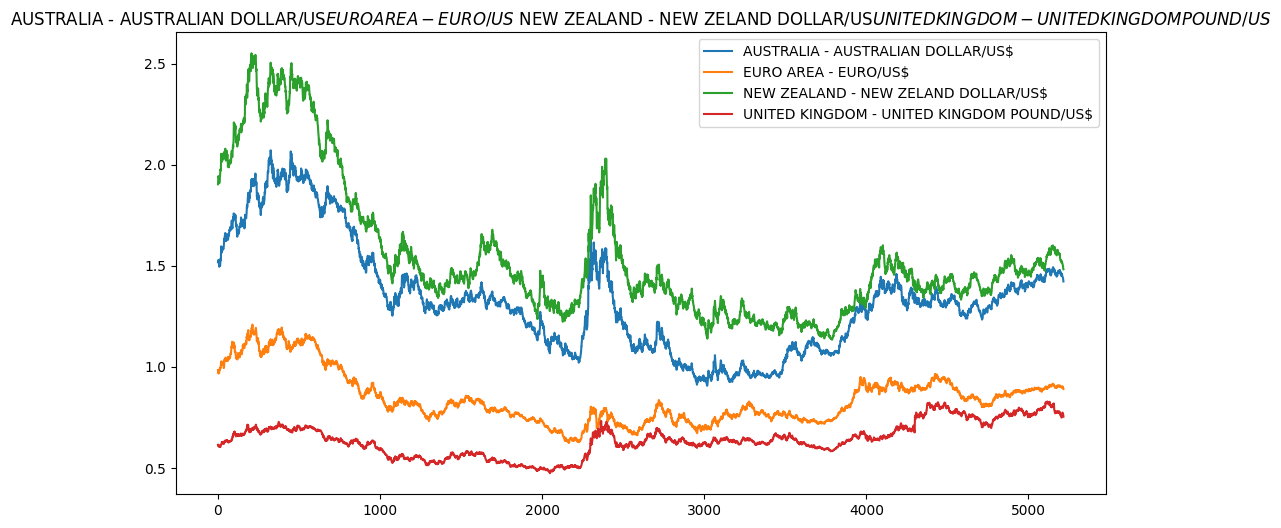

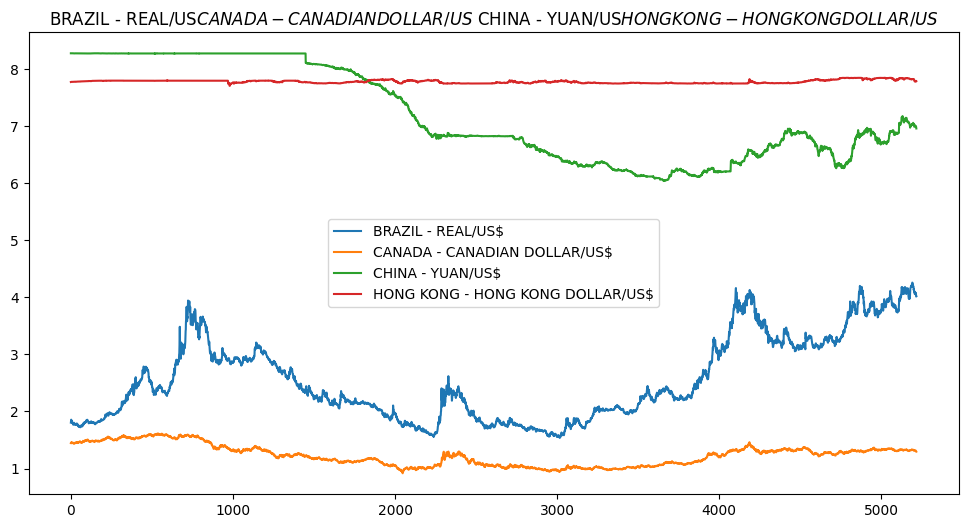

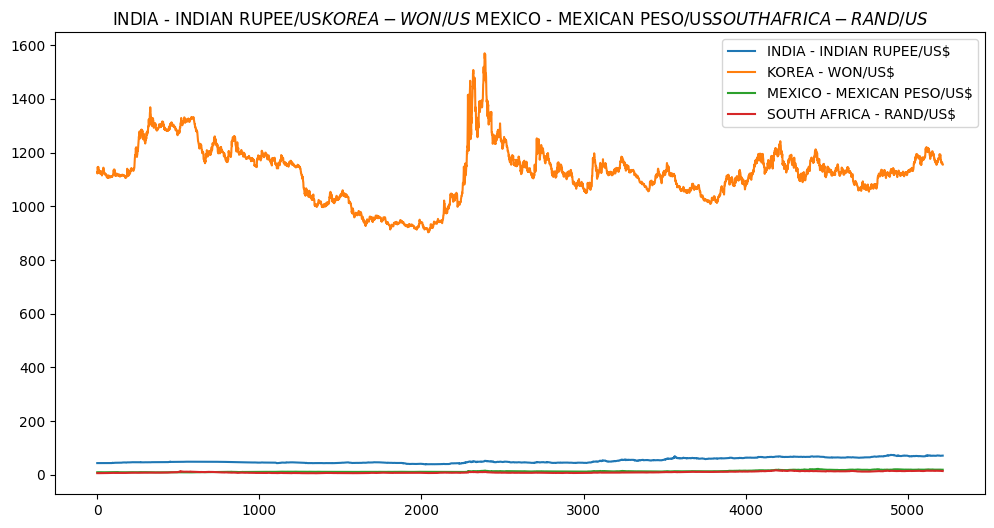

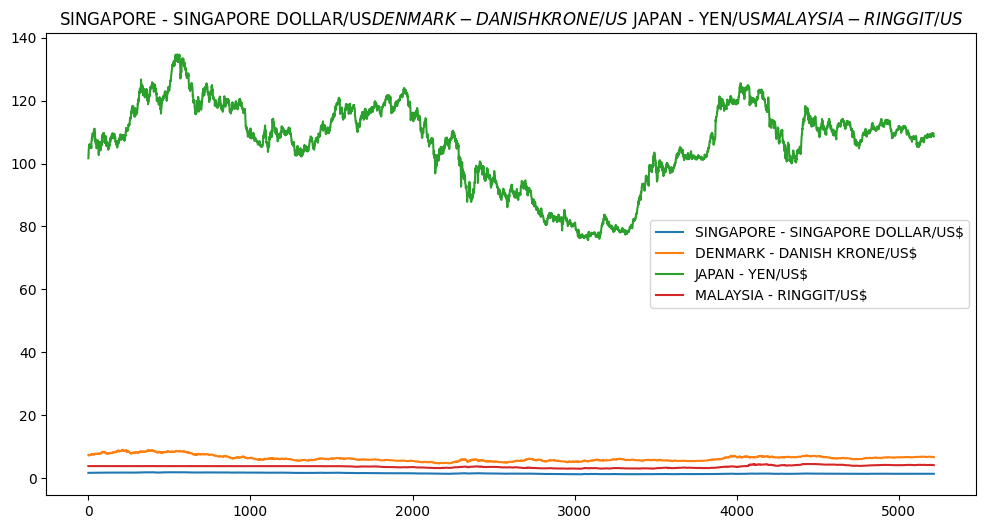

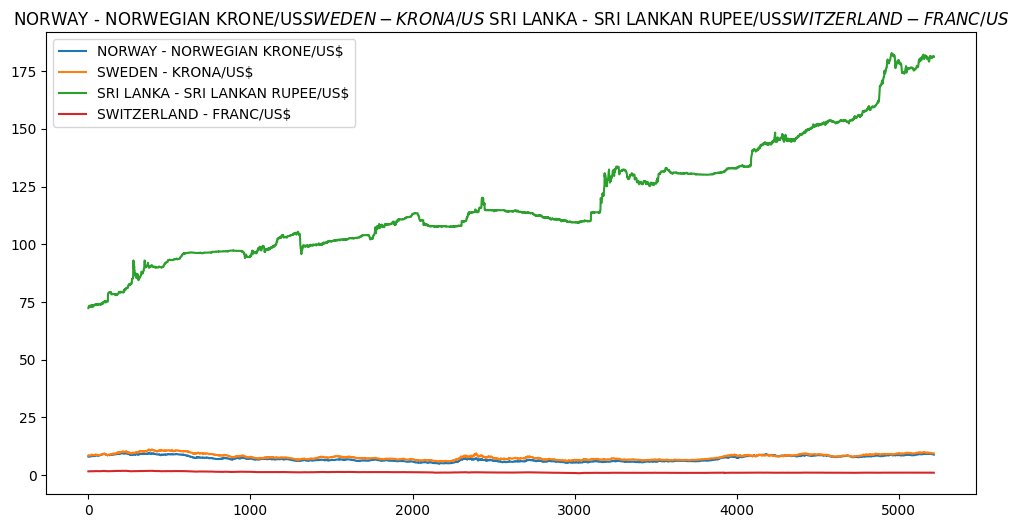

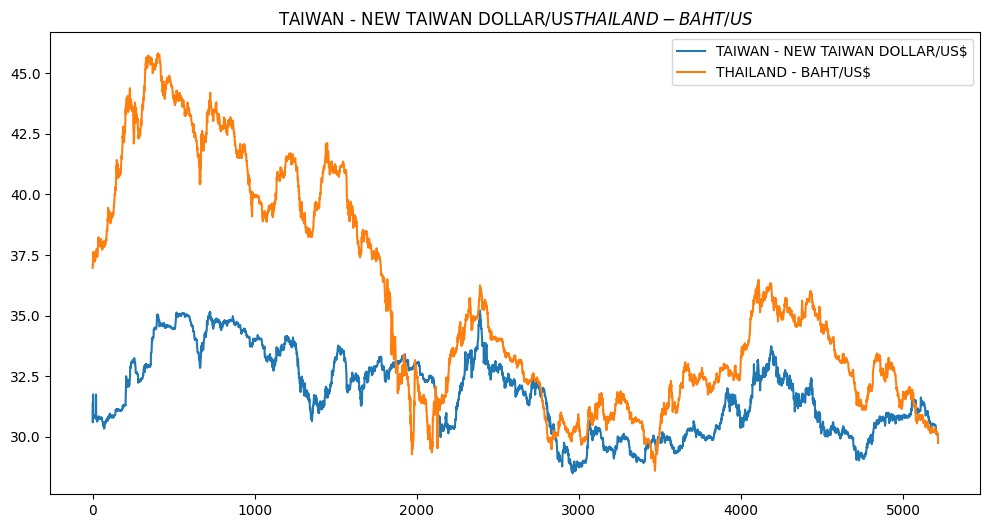

In [10]:
# Plotting Time-series
# Spliting currencies into groups of 4
col_grps = [df.columns[i:i+4] for i in range(1, len(df.columns), 4)]

for grp in col_grps:
  df[grp].plot(figsize=(12,6), title=" ".join(grp))
  plt.show()

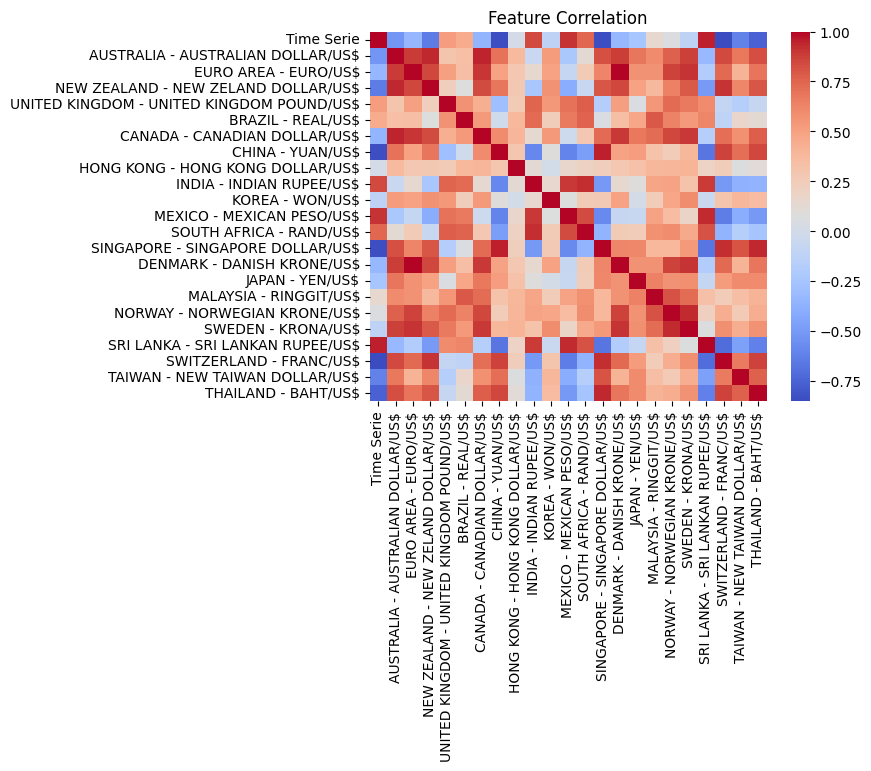

In [11]:
# Plotting the correlation of the variables
# Correlation heatmap
sns.heatmap(df.corr(), cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation')
plt.show()

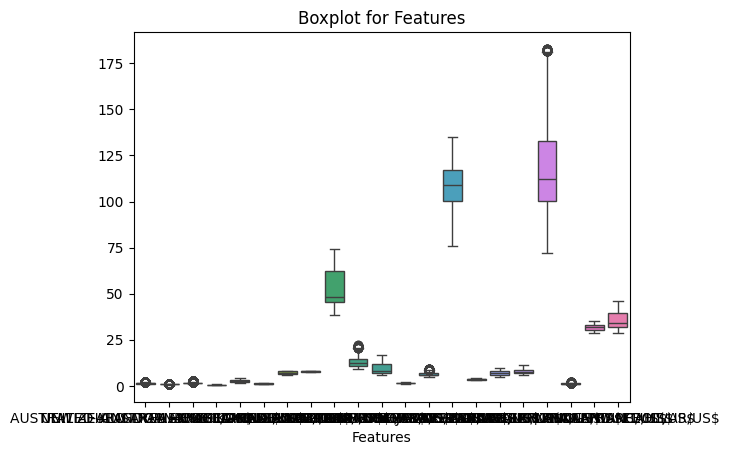

In [12]:
# Boxplot of features
sns.boxplot(data=df.drop('KOREA - WON/US$',axis=1))
plt.title('Boxplot for Features')
plt.xlabel('Features')
plt.show()

In [13]:
#selecting currency

options = {
    'AUSTRALIAN DOLLAR': 'AUSTRALIA - AUSTRALIAN DOLLAR/US$',
    'EURO': 'EURO AREA - EURO/US$',
    'NEW ZEALAND DOLLAR': 'NEW ZEALAND - NEW ZEALAND DOLLAR/US$',
    'GREAT BRITAIN POUNDS': 'UNITED KINGDOM - UNITED KINGDOM POUND/US$',
    'BRAZILIAN REAL': 'BRAZIL - REAL/US$',
    'CANADIAN DOLLAR': 'CANADA - CANADIAN DOLLAR/US$',
    'CHINESE YUAN$': 'CHINA - YUAN/US$',
    'HONG KONG DOLLAR': 'HONG KONG - HONG KONG DOLLAR/US$',
    'INDIAN RUPEE': 'INDIA - INDIAN RUPEE/US$',
    'KOREAN WON$': 'KOREA - WON/US$',
    'MEXICAN PESO': 'MEXICO - MEXICAN PESO/US$',
    'SOUTH AFRICAN RAND$': 'SOUTH AFRICA - RAND/US$',
    'SINGAPORE DOLLAR': 'SINGAPORE - SINGAPORE DOLLAR/US$',
    'DANISH KRONE': 'DENMARK - DANISH KRONE/US$',
    'JAPANESE YEN$': 'JAPAN - YEN/US$',
    'MALAYSIAN RINGGIT': 'MALAYSIA - RINGGIT/US$',
    'NORWEGIAN KRONE': 'NORWAY - NORWEGIAN KRONE/US$',
    'SWEDEN KRONA': 'SWEDEN - KRONA/US$',
    'SRILANKAN RUPEE': 'SRI LANKA - SRI LANKAN RUPEE/US$',
    'SWISS FRANC': 'SWITZERLAND - FRANC/US$',
    'NEW TAIWAN DOLLAR': 'TAIWAN - NEW TAIWAN DOLLAR/US$',
    'THAI BAHT': 'THAILAND - BAHT/US$'
}

selected_option = 'SRILANKAN RUPEE' #select currency here to train model 

In [14]:
df_selected = df[['Time Serie',options.get(selected_option)]]
df_selected.head()

Time Serie  SRI LANKA - SRI LANKAN RUPEE/US$
0 2000-01-03                             72.30
1 2000-01-04                             72.65
2 2000-01-05                             72.95
3 2000-01-06                             72.95
4 2000-01-07                             73.15

In [15]:
# Preparing features for modeling 

# Preparing data for tensorflow
def Sequential_Input_LSTM(df, input_sequence = 10):
    # df is the data being split into X,y
    # input_sequence is the number of days used to forecast the next day.
    df_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_np) - input_sequence):
        row = [a for a in df_np[i:i + input_sequence]]
        X.append(row)
        label = df_np[i + input_sequence]
        y.append(label)  

    return np.array(X), np.array(y)


# Splitting data for LightGBM model 
def lgb_sequence(df, n_input=10):
    X = []
    y = []
    for i in range(len(df) - n_input):
        X.append(df[i:i+n_input])
        y.append(df[i + n_input])
        
    return np.array(X), np.array(y) 


In [16]:
def train_val_test_split(X,y):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=22)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=22)

    return X_train, X_val, X_test, y_train, y_val, y_test
    

In [17]:
# Model 1 : AutoTS

def Creating_AutoTS_model(df_selected, options, selected_option):
    forecast=10 # no. of days for forecasting

    # Test-train split 
    # Excluding the points to be predicted
    df_train = df_selected.iloc[:-forecast] # Excluding the points to be predicted
    
    # Creating test data to align with prediction
    y_test = df_selected[[options[selected_option]]].iloc[-forecast:]
        
    # Creating AutoTS model
    model1 = AutoTS(forecast_length=int(forecast), frequency='infer', ensemble='simple', drop_data_older_than_periods=200, verbose=0)

    # Fitting model 
    model1 = model1.fit(df_train, date_col = 'Time Serie', value_col=options[selected_option], id_col=None)

    # Predictions
    #generating forecasts
    prediction = model1.predict()
    forecast = prediction.forecast

    # Aligning indices
    y_test.index = forecast.index 

    # Extracting currency values only 
    y_test = y_test[options[selected_option]].values
    y_pred = forecast[options[selected_option]].values


    return model1, y_test, y_pred

In [18]:
# Model 2: LSTM using Tersorflow

def Creating_LSTM_model(n_input, X_train, X_val, X_test, y_train, y_val, y_test):
    
    model2 = Sequential()

    n_features =1 
    model2.add(InputLayer((n_input,n_features)))
    model2.add(LSTM(100, return_sequences = True))     
    model2.add(LSTM(100, return_sequences = True))
    model2.add(LSTM(50))
    model2.add(Dense(8, activation = 'relu'))
    model2.add(Dense(1, activation = 'linear'))

    model2.summary()

    model2.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.0001), metrics = [RootMeanSquaredError()])
    early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

    model2.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 50, callbacks = [early_stop], verbose=0)

    # Prediction 
    y_pred = model2.predict(X_test).flatten()

    return model2, y_test, y_pred


In [19]:
# Model 3 
def Creating_LightGBM_model(X_train, X_val, X_test, y_train, y_val, y_test):
    # Data preperations 
    

    # Creating LightGBM datasets
    lgb_train_data = lgb.Dataset(X_train, label=y_train)
    lgb_val_data = lgb.Dataset(X_val, label=y_val, reference=lgb_train_data)

    # Define hyperparameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1
        
    }
    # Train the LightGBM model
    num_round = 500
    model3 = lgb.train(params, lgb_train_data, num_round, valid_sets=[lgb_val_data])

    # Prediction 
    y_pred = model3.predict(X_test)

    return model3, y_test, y_pred
        

In [20]:
def model_selection_per_currency(df_selected, options, selected_option):

    autots_model, y_test_autots, y_pred_autots = Creating_AutoTS_model(df_selected, options, selected_option)
    
    X, y = Sequential_Input_LSTM(df_selected.iloc[:,1])
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X,y)
    n_input = 10
    lstm_model, y_test_lstm, y_pred_lstm = Creating_LSTM_model(n_input, X_train, X_val, X_test, y_train, y_val, y_test)

    X1,y1 = lgb_sequence(df_selected.iloc[:,1].values) 
    X1 = X1.reshape(X1.shape[0], -1)  
    X1_train, X1_val, X1_test, y1_train, y1_val, y1_test = train_val_test_split(X1,y1)
    lgb_model, y_test_lgb, y_pred_lgb = Creating_LightGBM_model(X1_train, X1_val, X1_test, y1_train, y1_val, y1_test)

    return autots_model, y_test_autots, y_pred_autots, lstm_model, y_test_lstm, y_pred_lstm, lgb_model, y_test_lgb, y_pred_lgb


In [92]:
# Creating models for each cuurency
currency_models = []

for selected_option in options:
    print('Selected Currency:', selected_option)
    col_name = options.get(selected_option)

    # Check if the selected_option is a column in df
    if col_name not in df.columns:
        print(f'{col_name} not found in dataframe columns')
        continue

    df_selected = df[['Time Serie', col_name]]
    autots_model, y_test_autots, y_pred_autots, lstm_model, y_test_lstm, y_pred_lstm, lgb_model, y_test_lgb, y_pred_lgb = model_selection_per_currency(df_selected, options, selected_option)

    currency_models.append({
        'currency': selected_option,
        'AutoTS_model': autots_model,
        'y_test_autots': y_test_autots,
        'y_pred_autots': y_pred_autots,
        'LSTM_model': lstm_model,
        'y_test_lstm': y_test_lstm,
        'y_pred_lstm': y_pred_lstm,
        'LGB_model': lgb_model,
        'y_test_lgb': y_test_lgb,
        'y_pred_lgb': y_pred_lgb       
    })


currency_df = pd.DataFrame(currency_models)
currency_df.set_index('currency', inplace=True)



Selected Currency: AUSTRALIAN DOLLAR
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in generation 0: Cassandra
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 41 in generation 0: Ca

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step
Selected Currency: EURO
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in generation 0: Cassandra
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in m

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
Selected Currency: NEW ZEALAND DOLLAR
NEW ZEALAND - NEW ZEALAND DOLLAR/US$ not found in dataframe columns
Selected Currency: GREAT BRITAIN POUNDS
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in g

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
Selected Currency: BRAZILIAN REAL
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in generation 0: Cassandra
Template Eval Error: ValueError('more than 1 year of data is required for holiday detecti

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Selected Currency: CANADIAN DOLLAR
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in generation 0: Cassandra
Template Eval Error: ValueError('more than 1 year of data is required for holiday det

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step
Selected Currency: CHINESE YUAN$
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in generation 0: Cassandra
Template Eval Error: ValueError('more than 1 year of data is required for holiday detectio

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step
Selected Currency: HONG KONG DOLLAR
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in generation 0: Cassandra
Template Eval Error: ValueError('more than 1 year of data is required for holiday de

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
Selected Currency: INDIAN RUPEE
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in generation 0: Cassandra
Template Eval Error: ValueError('more than 1 year of data is required for holiday detect

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step
Selected Currency: KOREAN WON$
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in generation 0: Cassandra
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step
Selected Currency: MEXICAN PESO
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in generation 0: Cassandra
Template Eval Error: ValueError('more than 1 year of data is required for holiday detect

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
Selected Currency: SOUTH AFRICAN RAND$
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in generation 0: Cassandra
Template Eval Error: ValueError('more than 1 year of data is required for holiday de

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
Selected Currency: SINGAPORE DOLLAR
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in generation 0: Cassandra
Template Eval Error: ValueError('more than 1 year of data is required for holiday detec

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step
Selected Currency: DANISH KRONE
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in generation 0: Cassandra
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step
Selected Currency: JAPANESE YEN$
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in generation 0: Cassandra
Template Eval Error: ValueError('more than 1 year of data is required for holiday detecti

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step
Selected Currency: MALAYSIAN RINGGIT
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in generation 0: Cassandra
Template Eval Error: ValueError('more than 1 year of data is required for holiday 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step
Selected Currency: NORWEGIAN KRONE
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in generation 0: Cassandra
Template Eval Error: ValueError('more than 1 year of data is required for holiday detec

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step
Selected Currency: SWEDEN KRONA
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in generation 0: Cassandra
Template Eval Error: ValueError('more than 1 year of data is required for holiday detectio

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step
Selected Currency: SRILANKAN RUPEE
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in generation 0: Cassandra
Template Eval Error: ValueError('more than 1 year of data is required for holiday detec

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step
Selected Currency: SWISS FRANC
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in generation 0: Cassandra
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 412ms/step
Selected Currency: NEW TAIWAN DOLLAR
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in generation 0: Cassandra
Template Eval Error: ValueError('more than 1 year of data is required for holiday 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
Selected Currency: THAI BAHT
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Template Eval Error: ValueError('Only gave one variable to VAR') in model 21 in generation 0: VAR
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22 in generation 0: VAR
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 25 in generation 0: FBProphet
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 26 in generation 0: DatepartRegression
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 35 in generation 0: FBProphet
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 38 in generation 0: ARCH
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 39 in generation 0: Cassandra
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step


In [38]:
# Function to compute the performance of each model 
def compute_perf(metrics, name, y_test, y_pred):
    metrics.append({
        'Model ': name,
        'MAE': mean_absolute_error(y_test, y_pred), # Determine the MAE (Mean absolute error)
        'RMSE': mean_squared_error(y_test, y_pred), # Determine the RMSE (Root mean squared error)
        'MAPE': np.mean(np.abs((np.array(y_test) - np.array(y_pred)) / np.array(y_test)) * 100) # Determine the MAPE (Mean Absolute Percentage Error)

    })

    return metrics


In [108]:
# Funcition to plot bar chart for the metrics 
def metrics_plots(df, option):
    print(df)

    # Visualising all results together using barplot 
    fig, ax = plt.subplots(figsize=(6,4))
    fig.suptitle(option)

    positions = np.arange(len(df))
    bar_width = 0.2 
    ax.bar(positions - 1.5 * bar_width, df.loc[:,'MAE'], width=bar_width, label='MAE')
    ax.bar(positions - 0.5 * bar_width, df.loc[:,'RMSE'], width=bar_width, label='RMSE')
    ax.bar(positions + 0.5 * bar_width, df.loc[:,'MAPE'], width=bar_width, label='MAPE')

    # Adding labels and title
    ax.set_xlabel('Model')
    ax.set_ylabel('Scores')
    ax.set_title(f'Comparison of Model Performances for {option}')

    # Adding legend and xticks
    ax.legend()
    ax.set_xticks(positions, ['AutoTS', 'LSTM', 'LGB'])
    plt.show()


    # Metric score for each model 
    fig, axes = plt.subplots(1,3,figsize=(11,4))
    fig.suptitle(option)


    axes[0].bar(df.loc[:,'Model '],df.loc[:,'MAE'])
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel('MAE Scores')
    axes[0].set_title('Comparison of MAE')

    axes[1].bar(df.loc[:,'Model '],df.loc[:,'RMSE'])
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('RMSE Scores')
    axes[1].set_title('Comparison of RMSE')

    axes[2].bar(df.loc[:,'Model '],df.loc[:,'MAPE'])
    axes[2].set_xlabel('Model')
    axes[2].set_ylabel('MAPE Scores')
    axes[2].set_title('Comparison of MAPE')

    plt.tight_layout(rect=[0.05, 0, 1, 0.95])
    plt.show
  

     

In [94]:
selection_list = list(options.keys())
print(selection_list)


['AUSTRALIAN DOLLAR', 'EURO', 'NEW ZEALAND DOLLAR', 'GREAT BRITAIN POUNDS', 'BRAZILIAN REAL', 'CANADIAN DOLLAR', 'CHINESE YUAN$', 'HONG KONG DOLLAR', 'INDIAN RUPEE', 'KOREAN WON$', 'MEXICAN PESO', 'SOUTH AFRICAN RAND$', 'SINGAPORE DOLLAR', 'DANISH KRONE', 'JAPANESE YEN$', 'MALAYSIAN RINGGIT', 'NORWEGIAN KRONE', 'SWEDEN KRONA', 'SRILANKAN RUPEE', 'SWISS FRANC', 'NEW TAIWAN DOLLAR', 'THAI BAHT']


In [98]:
currency_df.head()

AutoTS_model  \
currency                                                                  
AUSTRALIAN DOLLAR     Initiated AutoTS object with best model: \nEns...   
EURO                  Initiated AutoTS object with best model: \nEns...   
GREAT BRITAIN POUNDS  Initiated AutoTS object with best model: \nEns...   
BRAZILIAN REAL        Initiated AutoTS object with best model: \nEns...   
CANADIAN DOLLAR       Initiated AutoTS object with best model: \nEns...   

                                                          y_test_autots  \
currency                                                                  
AUSTRALIAN DOLLAR     [1.459, 1.452, 1.4489, 1.4457, 1.4445, 1.4428,...   
EURO                  [0.8998, 0.8986, 0.9029, 0.9016, 0.9022, 0.901...   
GREAT BRITAIN POUNDS  [0.7646, 0.7672, 0.7671, 0.7742, 0.7719, 0.770...   
BRAZILIAN REAL        [4.0624, 4.058, 4.0859, 4.0621, 4.0833, 4.0717...   
CANADIAN DOLLAR       [1.3117, 1.3122, 1.317, 1.3167, 1.316, 1.3142,...   

                                                          y_pred_autots  \
currency                                                                  
AUSTRALIAN DOLLAR     [1.45908, 1.4607039388281595, 1.46026319888371...   
EURO                  [0.898555, 0.8992755917681997, 0.8988834122255...   
GREAT BRITAIN POUNDS  [0.765685, 0.7678012298066387, 0.7637918890396...   
BRAZILIAN REAL        [4.0673, 4.133020847463925, 4.096738425109359,...   
CANADIAN DOLLAR       [1.31619, 1.3161754052107202, 1.31612540521072...   

                                                      LSTM_model  \
currency                                                           
AUSTRALIAN DOLLAR     <Sequential name=sequential_1, built=True>   
EURO                  <Sequential name=sequential_1, built=True>   
GREAT BRITAIN POUNDS  <Sequential name=sequential_2, built=True>   
BRAZILIAN REAL        <Sequential name=sequential_1, built=True>   
CANADIAN DOLLAR       <Sequential name=sequential_2, built=True>   

                                                            y_test_lstm  \
currency                                                                  
AUSTRALIAN DOLLAR     [1.1206, 0.9845, 1.074, 1.2752, 1.2644, 1.3287...   
EURO                  [0.7315, 0.721, 0.6718, 0.8143, 0.7521, 0.8272...   
GREAT BRITAIN POUNDS  [0.6082, 0.6131, 0.6003, 0.7204, 0.5095, 0.565...   
BRAZILIAN REAL        [2.4015, 1.66, 1.727, 3.262, 2.141, 2.27985, 2...   
CANADIAN DOLLAR       [1.0634, 0.9733, 1.05, 1.2545, 1.1482, 1.1627,...   

                                                            y_pred_lstm  \
currency                                                                  
AUSTRALIAN DOLLAR     [1.1215687, 0.9915102, 1.096888, 1.2407241, 1....   
EURO                  [0.7294351, 0.73089653, 0.6764414, 0.8026775, ...   
GREAT BRITAIN POUNDS  [0.6104276, 0.6194386, 0.6061536, 0.7066998, 0...   
BRAZILIAN REAL        [2.3470538, 1.6412305, 1.706161, 3.1722965, 2....   
CANADIAN DOLLAR       [1.0651367, 0.98454976, 1.068106, 1.2351999, 1...   

                                                              LGB_model  \
currency                                                                  
AUSTRALIAN DOLLAR     <lightgbm.basic.Booster object at 0x000002830D...   
EURO                  <lightgbm.basic.Booster object at 0x000002833A...   
GREAT BRITAIN POUNDS  <lightgbm.basic.Booster object at 0x000002834F...   
BRAZILIAN REAL        <lightgbm.basic.Booster object at 0x0000028351...   
CANADIAN DOLLAR       <lightgbm.basic.Booster object at 0x000002835B...   

                                                             y_test_lgb  \
currency                                                                  
AUSTRALIAN DOLLAR     [1.1206, 0.9845, 1.074, 1.2752, 1.2644, 1.3287...   
EURO                  [0.7315, 0.721, 0.6718, 0.8143, 0.7521, 0.8272...   
GREAT BRITAIN POUNDS  [0.6082, 0.6131, 0.6003, 0.7204, 0.5095, 0.565...   
BRAZILIAN REAL        [2.4015, 1.66, 1.727, 3.262, 

In [103]:
print('Selection List:')
print(selection_list)
print('Currencies listed in Dataframe:')
print(currency_df.index)

Selection List:
['AUSTRALIAN DOLLAR', 'EURO', 'NEW ZEALAND DOLLAR', 'GREAT BRITAIN POUNDS', 'BRAZILIAN REAL', 'CANADIAN DOLLAR', 'CHINESE YUAN$', 'HONG KONG DOLLAR', 'INDIAN RUPEE', 'KOREAN WON$', 'MEXICAN PESO', 'SOUTH AFRICAN RAND$', 'SINGAPORE DOLLAR', 'DANISH KRONE', 'JAPANESE YEN$', 'MALAYSIAN RINGGIT', 'NORWEGIAN KRONE', 'SWEDEN KRONA', 'SRILANKAN RUPEE', 'SWISS FRANC', 'NEW TAIWAN DOLLAR', 'THAI BAHT']
Currencies listed in Dataframe:
Index(['AUSTRALIAN DOLLAR', 'EURO', 'GREAT BRITAIN POUNDS', 'BRAZILIAN REAL',
       'CANADIAN DOLLAR', 'CHINESE YUAN$', 'HONG KONG DOLLAR', 'INDIAN RUPEE',
       'KOREAN WON$', 'MEXICAN PESO', 'SOUTH AFRICAN RAND$',
       'SINGAPORE DOLLAR', 'DANISH KRONE', 'JAPANESE YEN$',
       'MALAYSIAN RINGGIT', 'NORWEGIAN KRONE', 'SWEDEN KRONA',
       'SRILANKAN RUPEE', 'SWISS FRANC', 'NEW TAIWAN DOLLAR', 'THAI BAHT'],
      dtype='object', name='currency')


AUSTRALIAN DOLLAR
   Model        MAE      RMSE      MAPE
0  AutoTS  0.019647  0.000526  1.368867
1    LSTM  0.018124  0.000631  1.353169
2     LGB  0.008785  0.000156  0.654623


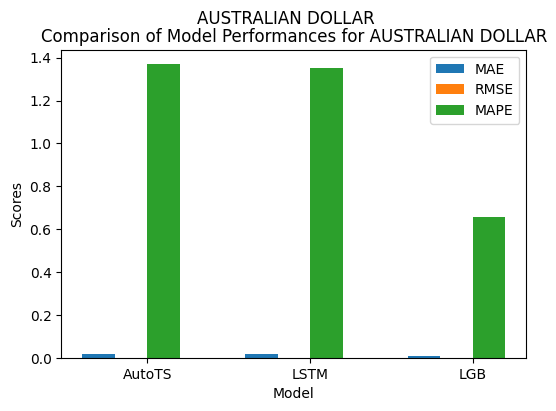

EURO
   Model        MAE      RMSE      MAPE
0  AutoTS  0.003646  0.000018  0.406656
1    LSTM  0.009391  0.000159  1.097965
2     LGB  0.004324  0.000034  0.506690


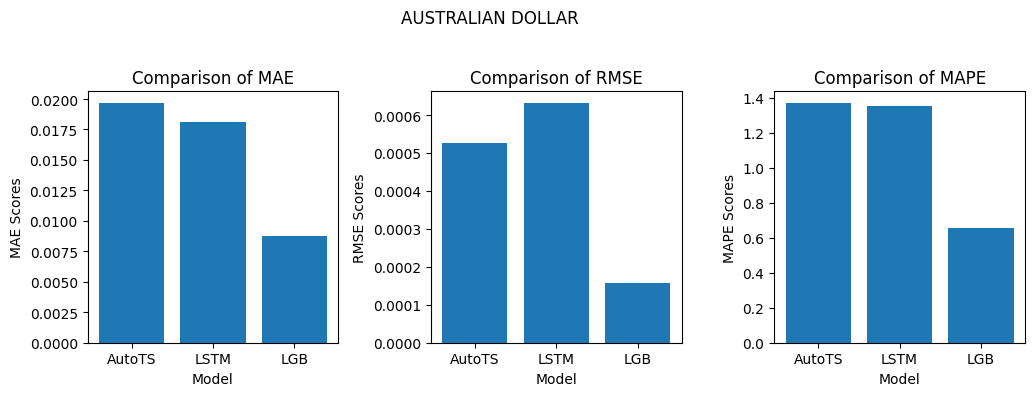

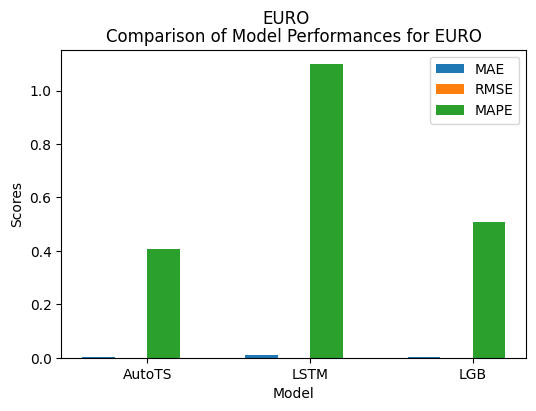

NEW ZEALAND DOLLAR
NEW ZEALAND DOLLAR not found in dataframe columns
GREAT BRITAIN POUNDS
   Model        MAE      RMSE      MAPE
0  AutoTS  0.004567  0.000032  0.595511
1    LSTM  0.006873  0.000087  1.060573
2     LGB  0.003182  0.000018  0.491546


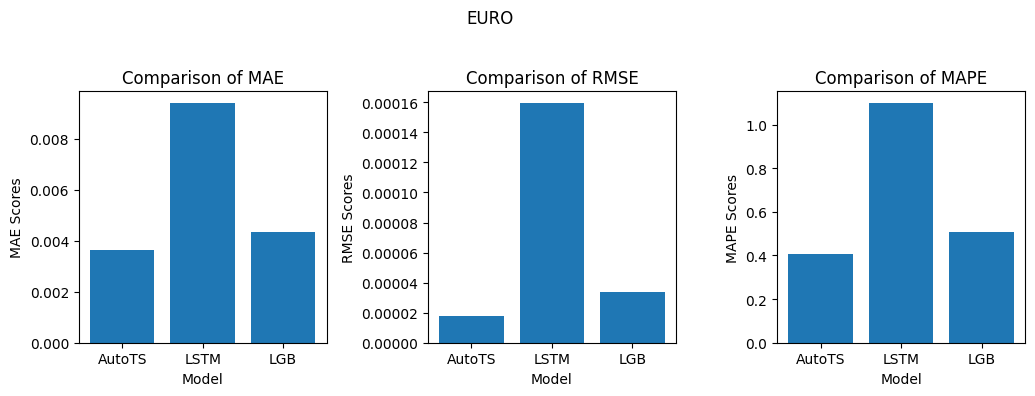

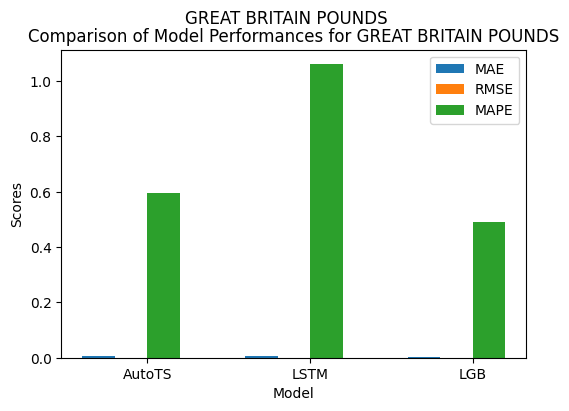

BRAZILIAN REAL
   Model        MAE      RMSE      MAPE
0  AutoTS  0.069597  0.006842  1.720979
1    LSTM  0.043340  0.003837  1.673374
2     LGB  0.021605  0.001050  0.810438


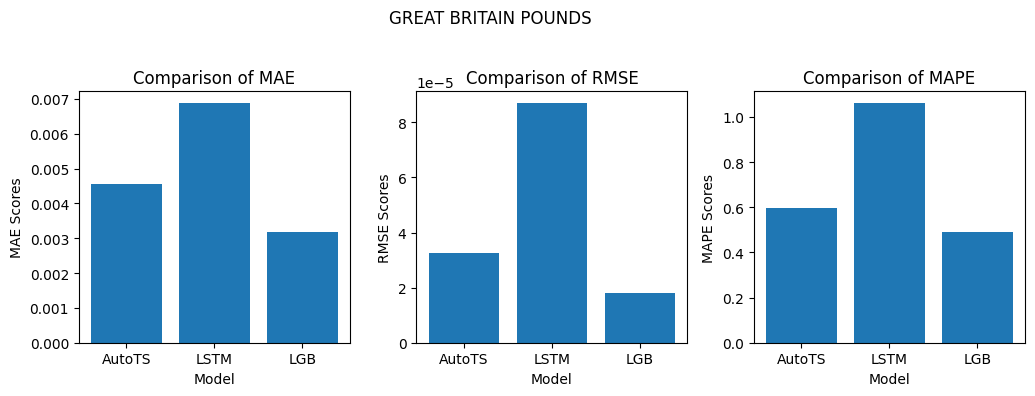

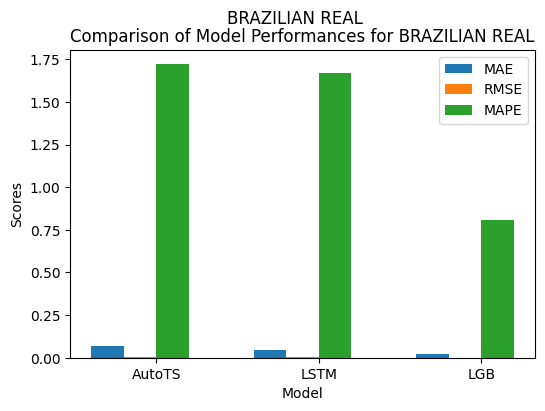

CANADIAN DOLLAR
   Model        MAE      RMSE      MAPE
0  AutoTS  0.005333  0.000061  0.408797
1    LSTM  0.011137  0.000230  0.916380
2     LGB  0.005407  0.000054  0.444966


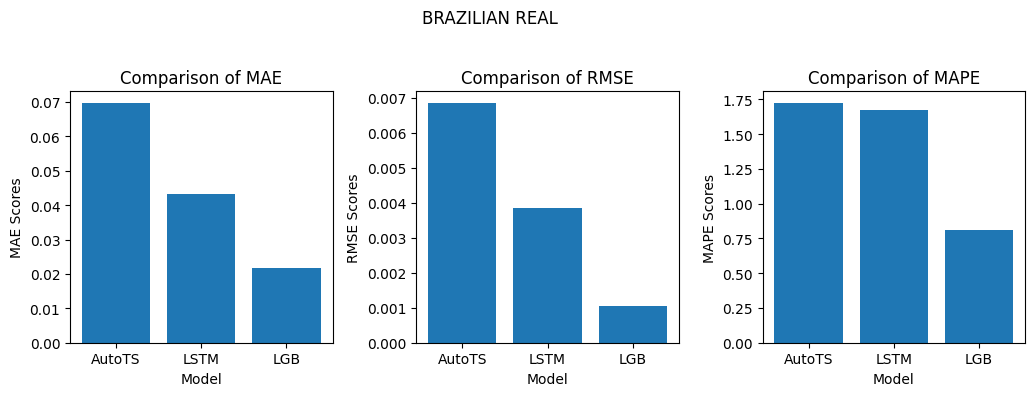

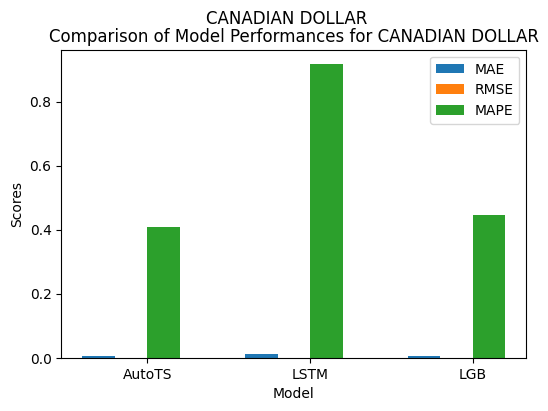

CHINESE YUAN$
   Model        MAE      RMSE      MAPE
0  AutoTS  0.017244  0.000565  0.246885
1    LSTM  0.028426  0.001548  0.418075
2     LGB  0.006090  0.000111  0.089092


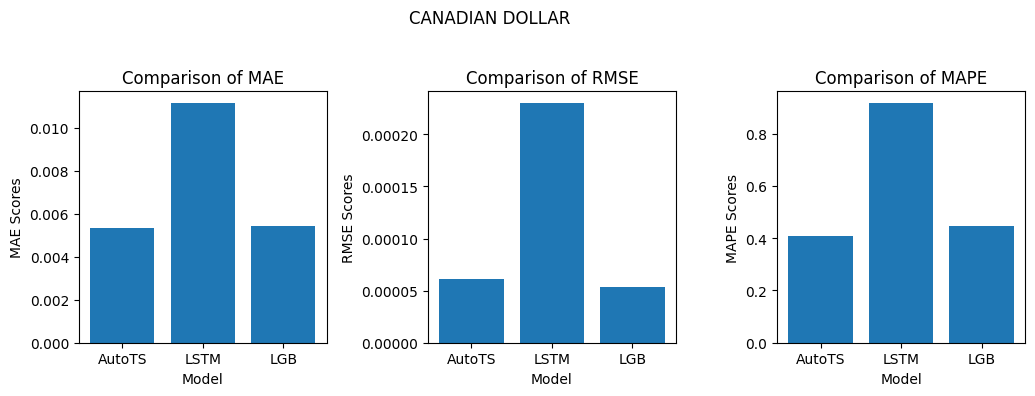

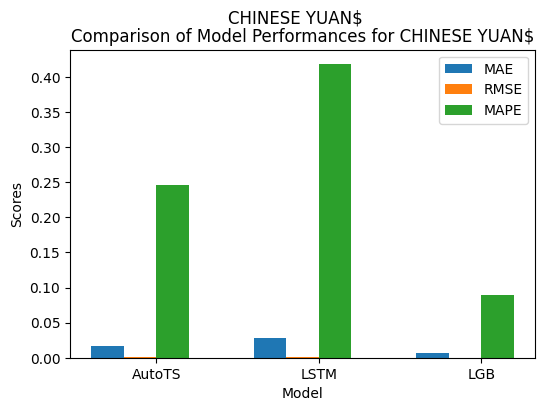

HONG KONG DOLLAR
   Model        MAE      RMSE      MAPE
0  AutoTS  0.007408  0.000084  0.095107
1    LSTM  0.023372  0.000739  0.300155
2     LGB  0.001605  0.000007  0.020605


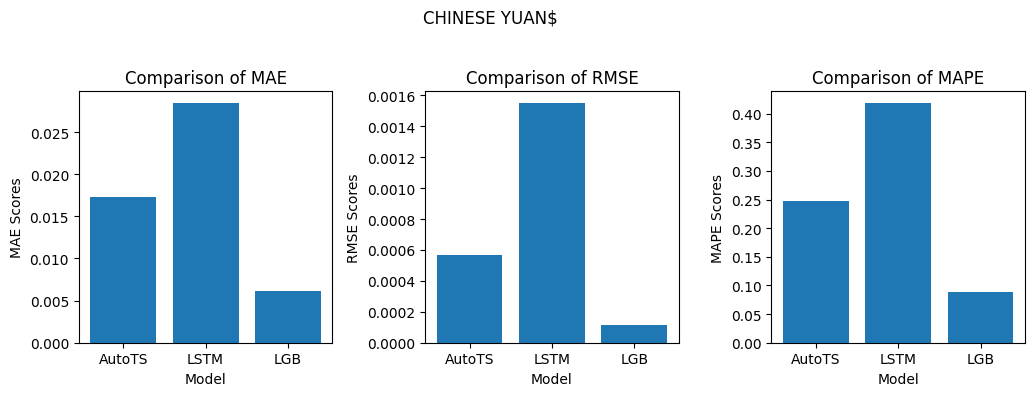

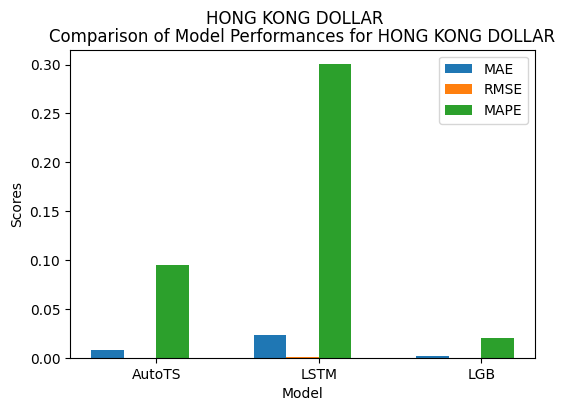

INDIAN RUPEE
   Model        MAE       RMSE       MAPE
0  AutoTS  0.133119   0.023536   0.186860
1    LSTM  8.842303  97.246069  16.435673
2     LGB  0.185757   0.077982   0.339631


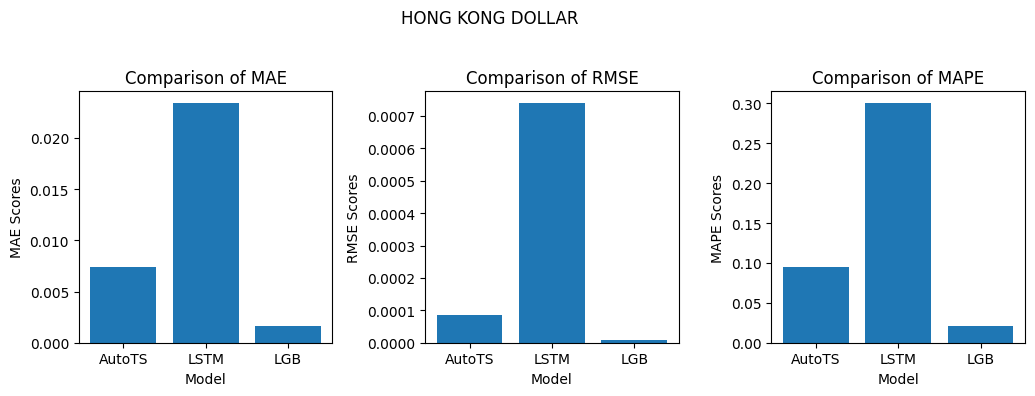

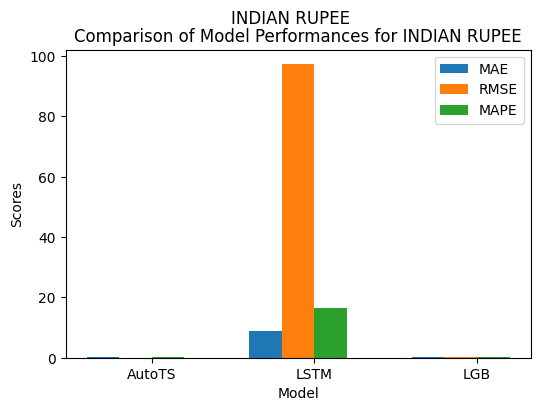

KOREAN WON$
   Model          MAE           RMSE       MAPE
0  AutoTS    5.241488      35.225183   0.451647
1    LSTM  983.390653  976938.561349  87.550000
2     LGB    5.463707      83.864781   0.470113


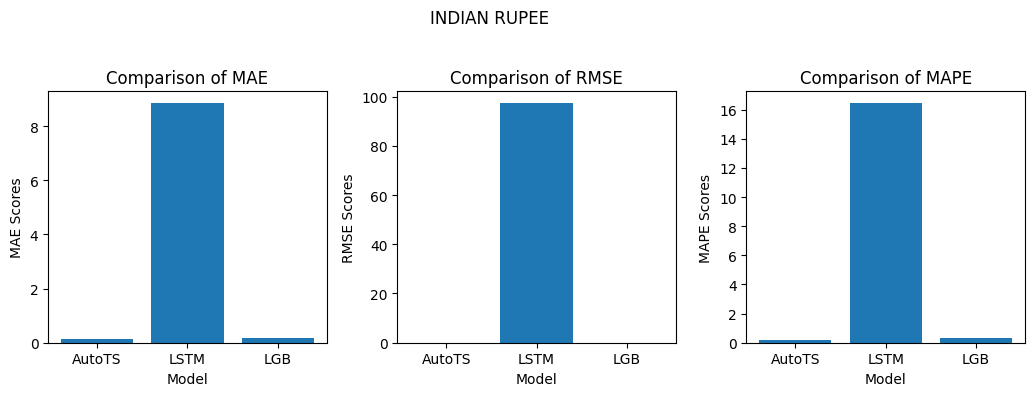

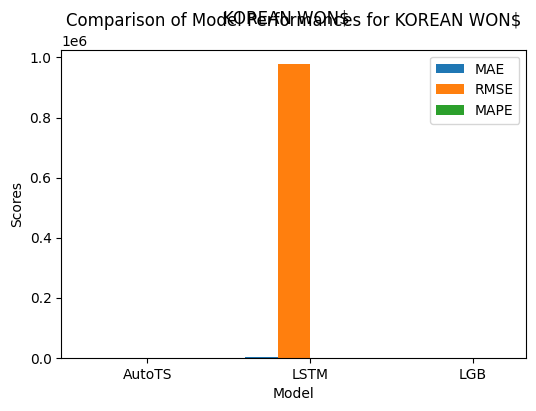

MEXICAN PESO
   Model        MAE       RMSE       MAPE
0  AutoTS  0.101873   0.017174   0.539628
1    LSTM  2.693080  11.319902  19.995411
2     LGB  0.073857   0.012667   0.524401


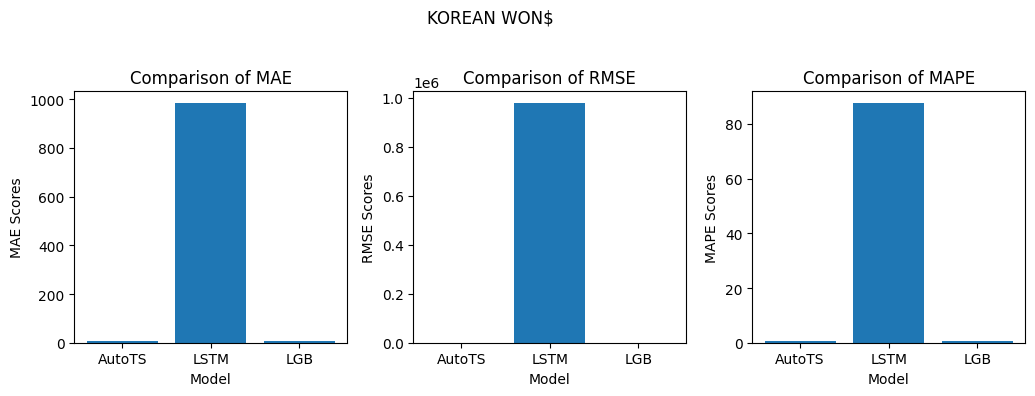

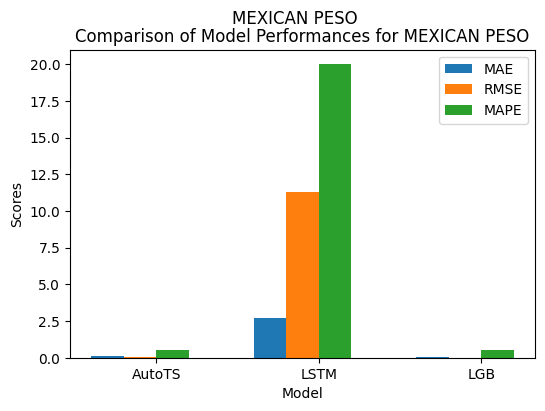

SOUTH AFRICAN RAND$
   Model        MAE      RMSE      MAPE
0  AutoTS  0.294667  0.093909  2.087831
1    LSTM  0.212438  0.109198  2.078467
2     LGB  0.090869  0.018695  0.902216


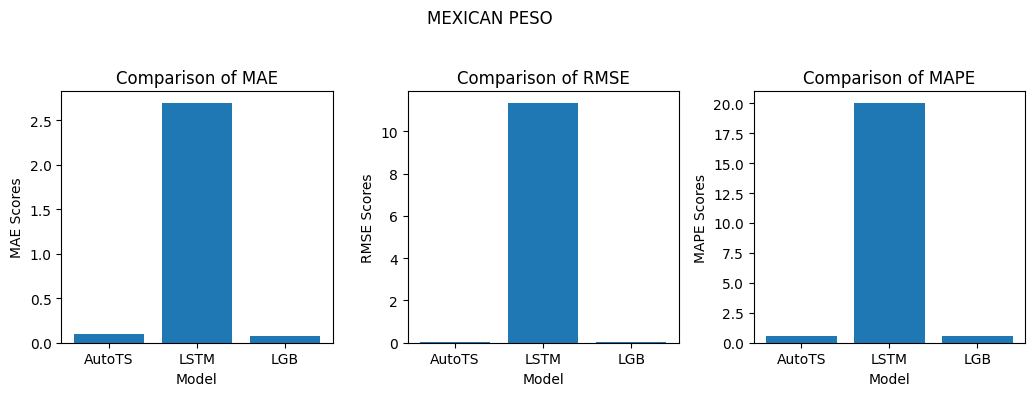

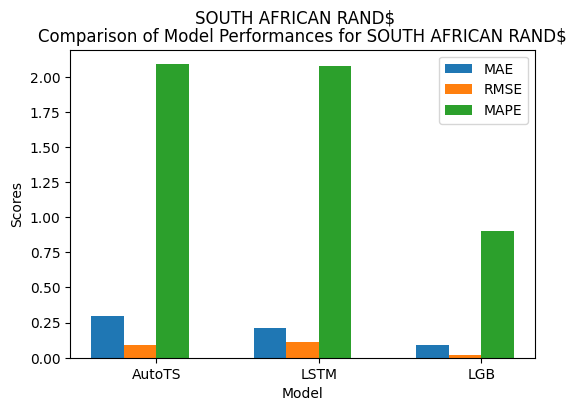

SINGAPORE DOLLAR
   Model        MAE      RMSE      MAPE
0  AutoTS  0.002397  0.000013  0.177637
1    LSTM  0.009496  0.000145  0.648409
2     LGB  0.003994  0.000030  0.273077


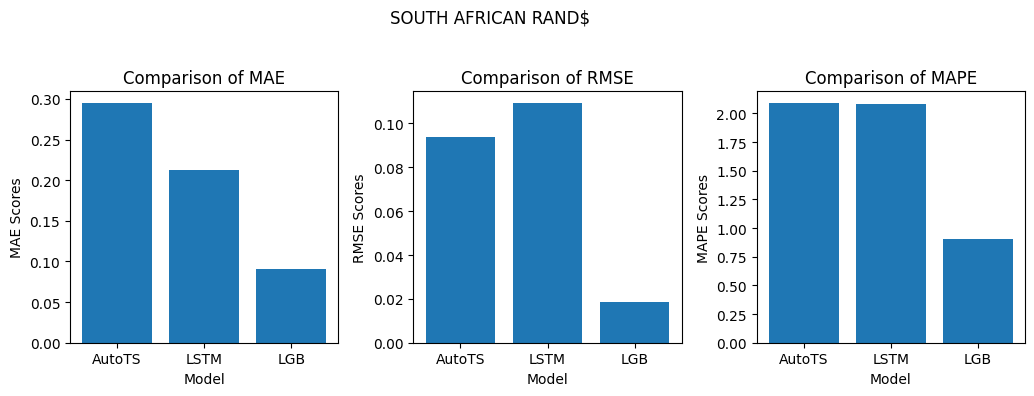

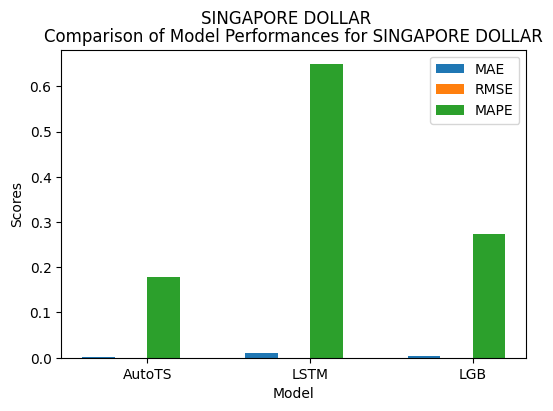

DANISH KRONE
   Model        MAE      RMSE      MAPE
0  AutoTS  0.028582  0.001132  0.426759
1    LSTM  0.069417  0.008927  1.088512
2     LGB  0.032482  0.002191  0.509758


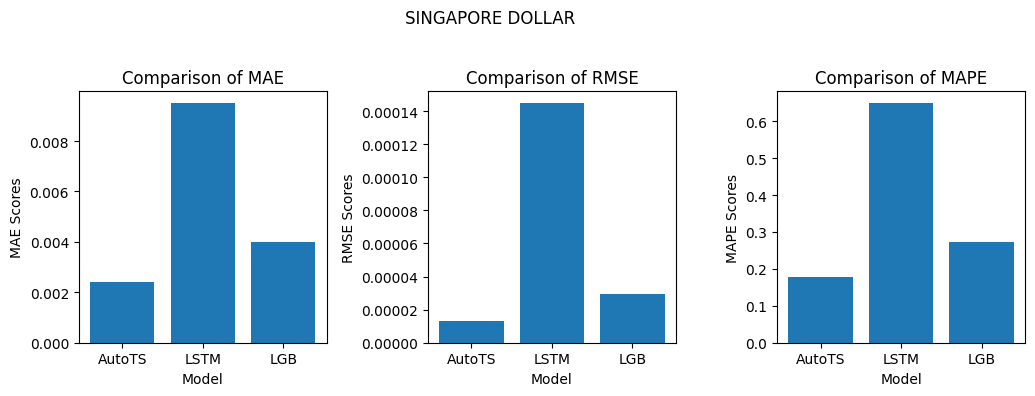

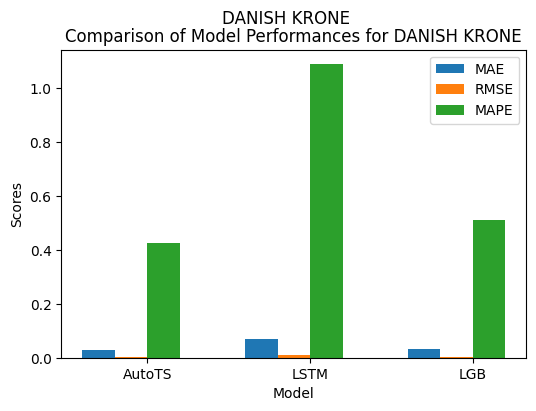

JAPANESE YEN$
   Model          MAE          RMSE       MAPE
0  AutoTS    0.395500      0.182982   0.361583
1    LSTM  106.181556  11431.877805  99.458219
2     LGB    0.560073      0.553917   0.528028


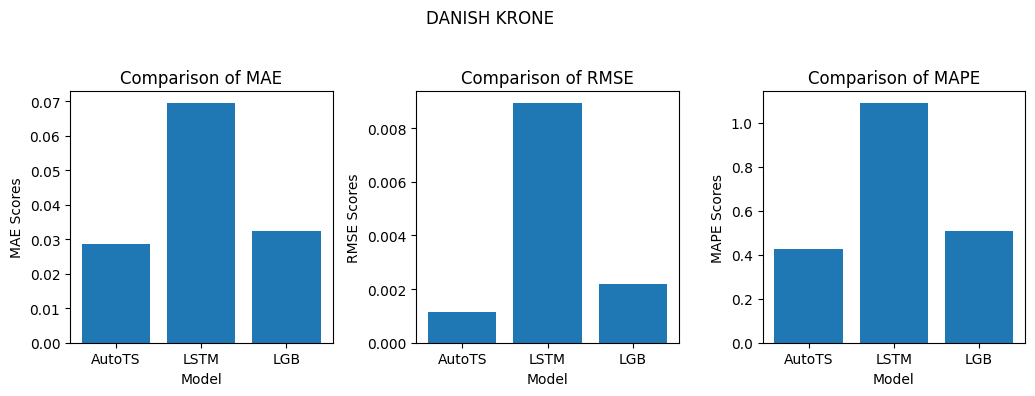

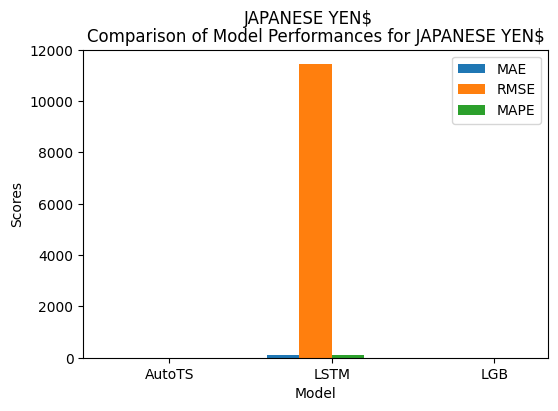

MALAYSIAN RINGGIT
   Model        MAE      RMSE      MAPE
0  AutoTS  0.006371  0.000123  0.155107
1    LSTM  0.025162  0.001477  0.695366
2     LGB  0.008729  0.000212  0.242937


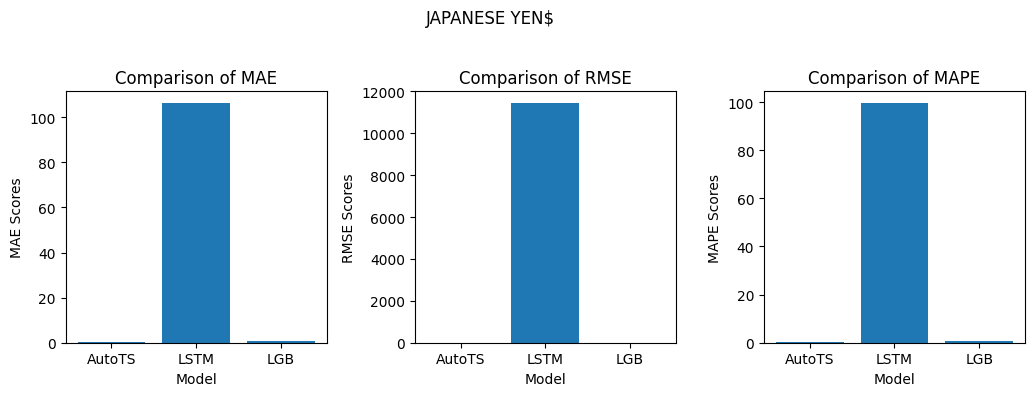

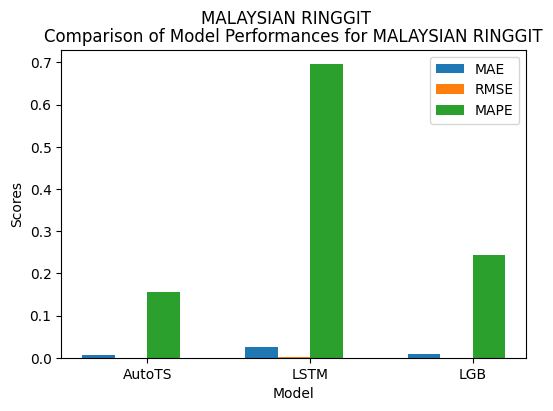

NORWEGIAN KRONE
   Model        MAE      RMSE      MAPE
0  AutoTS  0.165727  0.028362  1.865359
1    LSTM  0.113371  0.020843  1.609102
2     LGB  0.042807  0.003189  0.614424


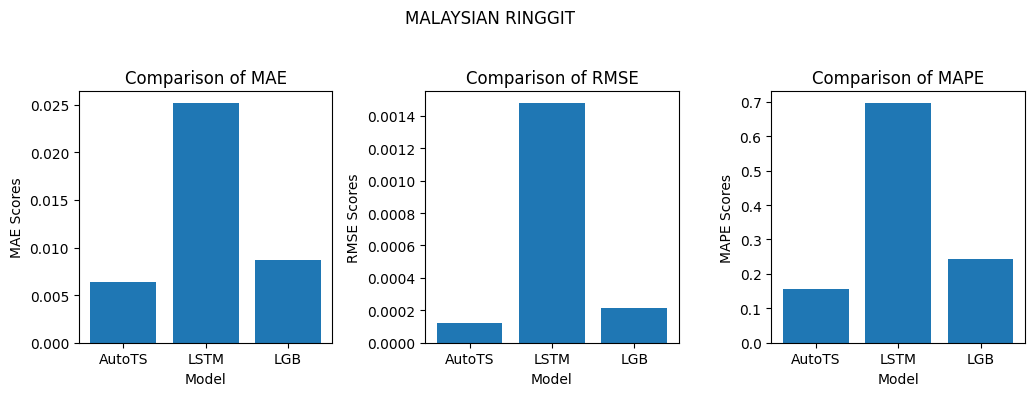

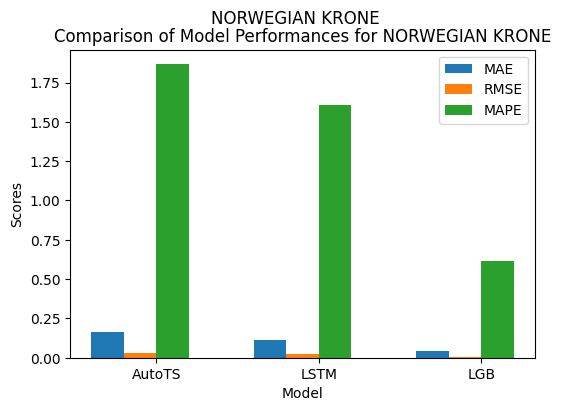

SWEDEN KRONA
   Model        MAE      RMSE      MAPE
0  AutoTS  0.066510  0.005023  0.707412
1    LSTM  0.087685  0.013454  1.101099
2     LGB  0.049118  0.004322  0.623646


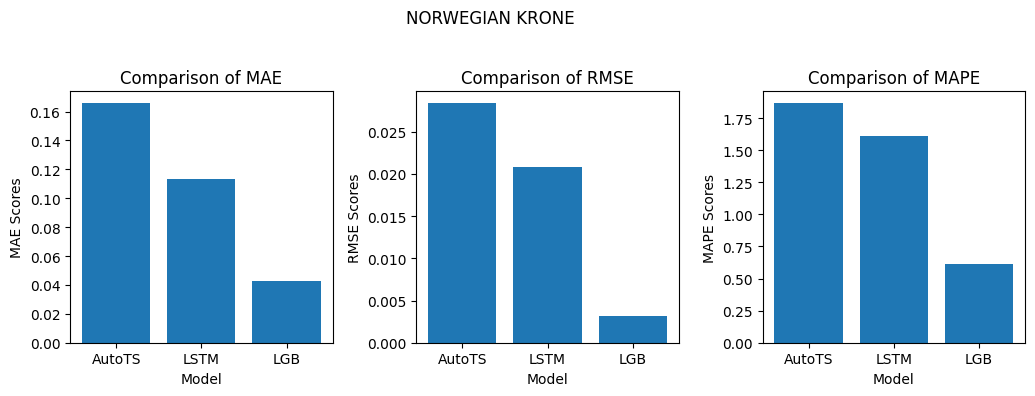

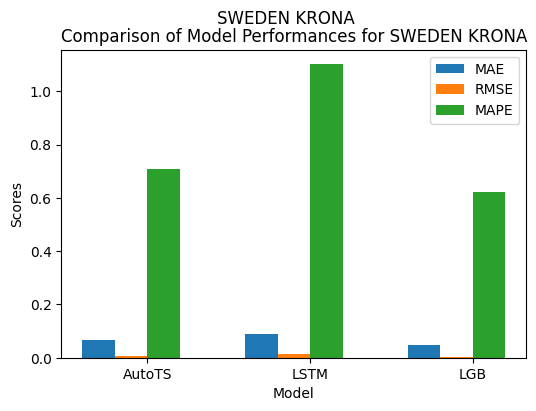

SRILANKAN RUPEE
   Model         MAE         RMSE       MAPE
0  AutoTS   0.435124     0.230437   0.239929
1    LSTM  26.208768  1182.964681  19.492374
2     LGB   0.213700     0.177055   0.183706


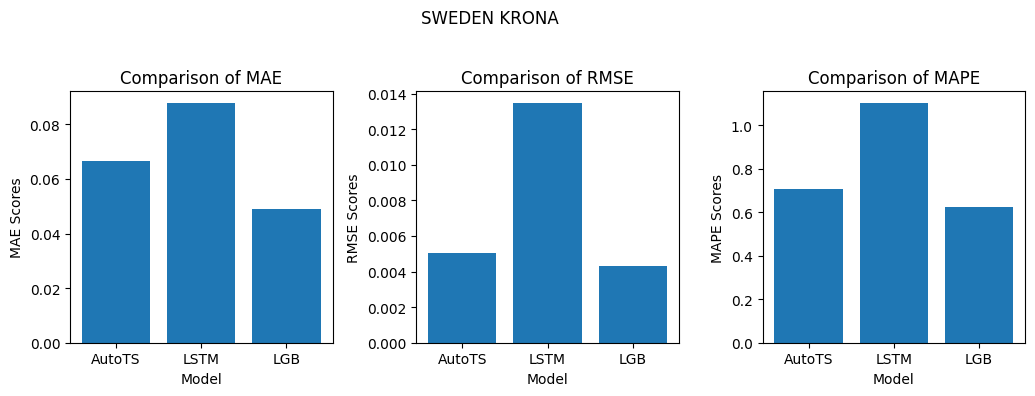

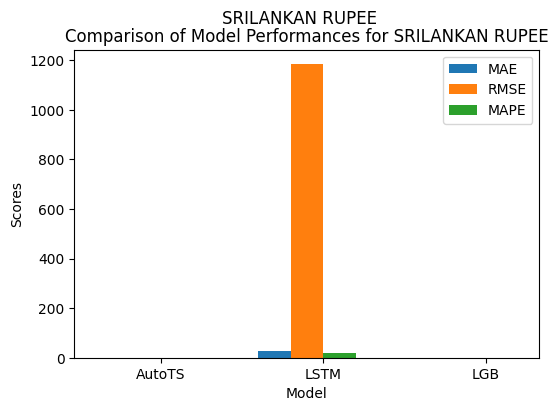

SWISS FRANC
   Model        MAE      RMSE      MAPE
0  AutoTS  0.006401  0.000068  0.657797
1    LSTM  0.014038  0.000350  1.213108
2     LGB  0.006056  0.000073  0.521456


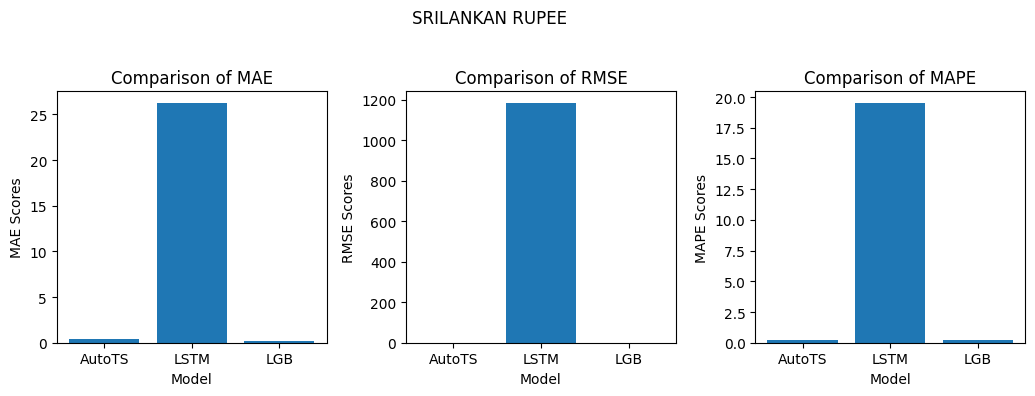

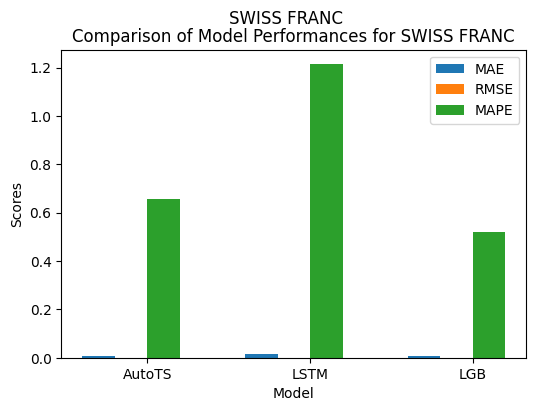

NEW TAIWAN DOLLAR
   Model        MAE      RMSE      MAPE
0  AutoTS  0.043952  0.004673  0.146394
1    LSTM  1.418784  2.725058  4.481902
2     LGB  0.071434  0.010252  0.225282


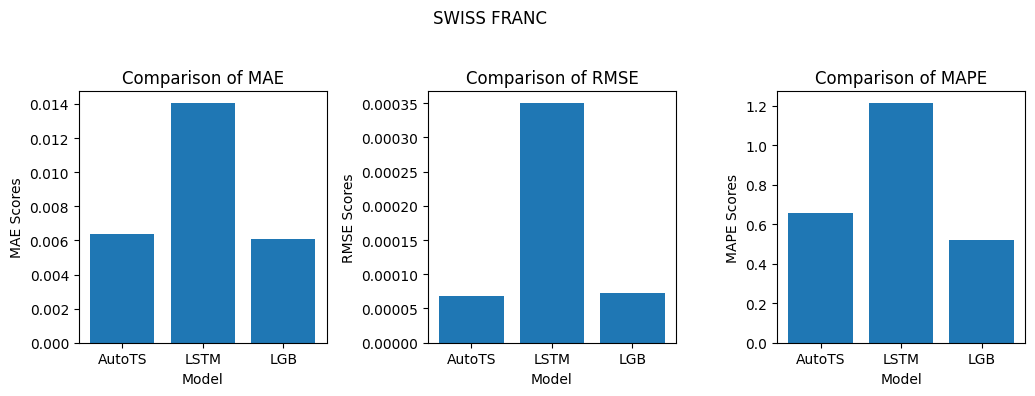

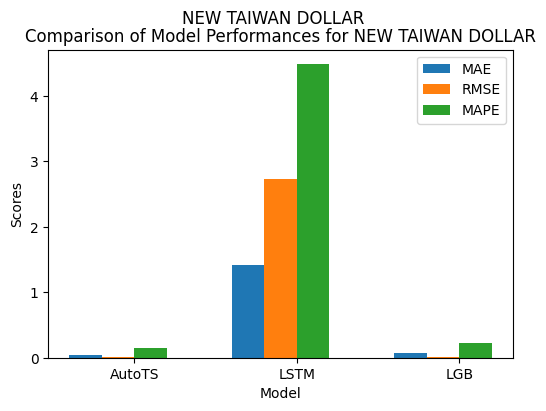

THAI BAHT
   Model        MAE       RMSE       MAPE
0  AutoTS  0.127618   0.035451   0.426066
1    LSTM  3.894460  20.475790  10.862857
2     LGB  0.102670   0.020129   0.292229


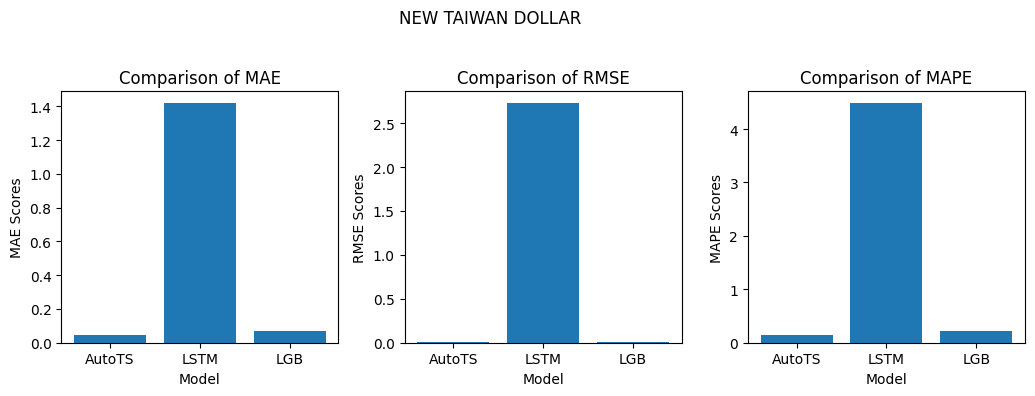

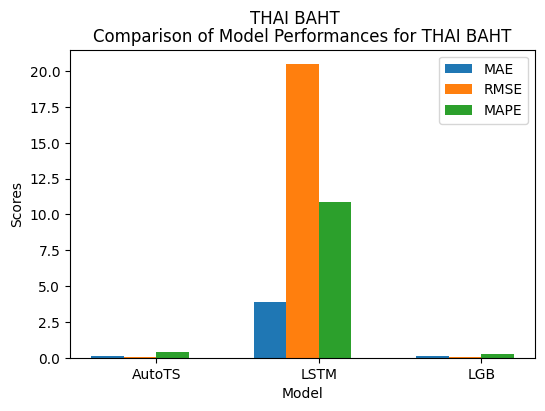

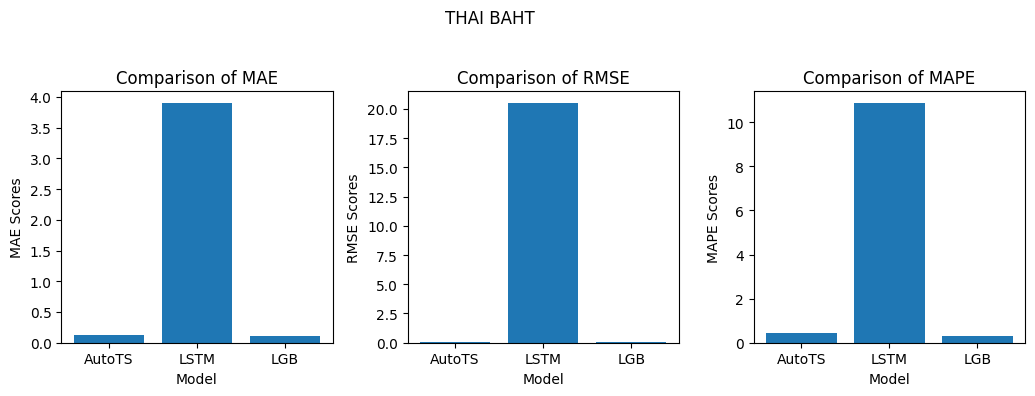

In [109]:
for selected_currency in selection_list:
    curency_metrics = []
    print(selected_currency)
    if selected_currency not in currency_df.index:
        print(f'{selected_currency} not found in dataframe columns')
        continue
    else : 
        curency_metrics = compute_perf(curency_metrics, 'AutoTS', currency_df.loc[selected_currency,'y_test_autots' ] , currency_df.loc[selected_currency, 'y_pred_autots'])
        curency_metrics = compute_perf(curency_metrics, 'LSTM', currency_df.loc[selected_currency,'y_test_lstm' ] , currency_df.loc[selected_currency, 'y_pred_lstm'] )
        curency_metrics = compute_perf(curency_metrics, 'LGB',currency_df.loc[selected_currency,'y_test_lgb' ] , currency_df.loc[selected_currency,'y_pred_lgb'])

        currency_metrics_df = pd.DataFrame(curency_metrics)
        
        metrics_plots(currency_metrics_df, selected_currency)
    

    
    

    

New Zealand Currency data could not be modeled due to an error.

### Best model for each currency: 
* 'AUSTRALIAN DOLLAR': LGB (performed the best on all 3 metrics )
* 'EURO': AutoTS (performed the best on all 3 metrics)
* 'GREAT BRITAIN POUNDS': LGB (performed the best all 3 metrics)
* 'BRAZILIAN REAL': LGB (performed the best all 3 metrics)
* 'CANADIAN DOLLAR': AutoTS (performed the best on all 3 metrics)
* 'CHINESE YUAN$': LGB (performed the best on all 3 metrics)
* 'HONG KONG DOLLAR': LGB (performed the best on all 3 metrics)
* 'INDIAN RUPEE': AutoTS (performed the best on all 3 metrics)
* 'KOREAN WON$': AutoTS (performed the best on all 3 metrics)
* 'MEXICAN PESO': LGB (performed the best on all 3 metrics)
* 'SOUTH AFRICAN RAND$': LGB (performed the best on all 3 metrics)
* 'SINGAPORE DOLLAR': AutoTS (performed best on all 3 metrics)
* 'DANISH KRONE': AutoTS (performed best on all 3 metrics)
* 'JAPANESE YEN$': AutoTS (performed the on all 3 metrics)
* 'MALAYSIAN RINGGIT': AutoTS (performed the best on all 3 metrics)
* 'NORWEGIAN KRONE': LGB (performed the best on all 3 metrics)
* 'SWEDEN KRONA': LGB (performed the best on all 3 metrics)
* 'SRILANKAN RUPEE': LGB (performed the best on all 3 metrics)
* 'SWISS FRANC': LGB (performed the best on MAE and MAPE, and there is a  )
* 'NEW TAIWAN DOLLAR': AutoTS (performed the best on all 3 metrics)
* 'THAI BAHT': LGB (performed the best on all 3 metrics)

## Saving best model for each currency:

In [121]:
import joblib
import pickle
# options: 'AutoTS_model', 'LSTM_model', 'LGB_model'
#'AUSTRALIAN DOLLAR': LGB 
joblib.dump(currency_df.loc['AUSTRALIAN DOLLAR', 'LGB_model'], "models/AUSD_model.pkl")

#'EURO': AutoTS 
with open("models/EU_model.pkl", "wb") as f:
    pickle.dump(currency_df.loc['EURO', 'AutoTS_model'], f)

#'GREAT BRITAIN POUNDS': LGB 
joblib.dump(currency_df.loc['GREAT BRITAIN POUNDS', 'LGB_model'], "models/GBP_model.pkl")

#'BRAZILIAN REAL': LGB 
joblib.dump(currency_df.loc['BRAZILIAN REAL', 'LGB_model'], "models/BR_model.pkl")

#'CANADIAN DOLLAR': AutoTS 
with open("models/CD_model.pkl", "wb") as f:
    pickle.dump(currency_df.loc['CANADIAN DOLLAR', 'AutoTS_model'], f)

#'CHINESE YUAN$': LGB 
joblib.dump(currency_df.loc['CHINESE YUAN$', 'LGB_model'], "models/CHI_model.pkl")

#'HONG KONG DOLLAR': LGB 
joblib.dump(currency_df.loc['HONG KONG DOLLAR', 'LGB_model'], "models/HKD_model.pkl")

#'INDIAN RUPEE': AutoTS 
with open("models/IR_model.pkl", "wb") as f:
    pickle.dump(currency_df.loc['INDIAN RUPEE', 'AutoTS_model'], f)

#'KOREAN WON$': AutoTS 
with open("models/KW_model.pkl", "wb") as f:
    pickle.dump(currency_df.loc['KOREAN WON$', 'AutoTS_model'], f)

#'MEXICAN PESO': LGB 
joblib.dump(currency_df.loc['MEXICAN PESO', 'LGB_model'], "models/MP_model.pkl")

#'SOUTH AFRICAN RAND$': LGB 
joblib.dump(currency_df.loc['SOUTH AFRICAN RAND$', 'LGB_model'], "models/ZAR_model.pkl")

#'SINGAPORE DOLLAR': AutoTS
with open("models/SD_model.pkl", "wb") as f:
    pickle.dump(currency_df.loc['SINGAPORE DOLLAR', 'AutoTS_model'], f)

#'DANISH KRONE': AutoTS 
with open("models/DK_model.pkl", "wb") as f:
    pickle.dump(currency_df.loc['DANISH KRONE', 'AutoTS_model'], f)

#'JAPANESE YEN$': AutoTS 
with open("models/JY_model.pkl", "wb") as f:
    pickle.dump(currency_df.loc['JAPANESE YEN$', 'AutoTS_model'], f)

#'MALAYSIAN RINGGIT': AutoTS 
with open("models/MR_model.pkl", "wb") as f:
    pickle.dump(currency_df.loc['MALAYSIAN RINGGIT', 'AutoTS_model'], f)

#'NORWEGIAN KRONE': LGB 
joblib.dump(currency_df.loc['NORWEGIAN KRONE', 'LGB_model'], "models/NK_model.pkl")

#'SWEDEN KRONA': LGB 
joblib.dump(currency_df.loc['SWEDEN KRONA', 'LGB_model'], "models/SK_model.pkl")

#'SRILANKAN RUPEE': LGB 
joblib.dump(currency_df.loc['SRILANKAN RUPEE', 'LGB_model'], "models/SR_model.pkl")

#'SWISS FRANC': LGB 
joblib.dump(currency_df.loc['SWISS FRANC', 'LGB_model'], "models/SF_model.pkl")

#'NEW TAIWAN DOLLAR': AutoTS 
with open("models/NTD_model.pkl", "wb") as f:
    pickle.dump(currency_df.loc['NEW TAIWAN DOLLAR', 'AutoTS_model'], f)


#'THAI BAHT': LGB
joblib.dump(currency_df.loc['THAI BAHT', 'LGB_model'], "models/TB_model.pkl")


['models/TB_model.pkl']